# Bayesian Neural Network (Classification) MCMC
Part of the Bayesian neural networks via MCMC: a Python-based tutorial.

This section of the tutorial covers the development of an MCMC algorithm applied to a Neural Network for classification problems.

### Imports

In [1]:
import os
import numpy as np
import pandas as pd
from ipywidgets import interact, fixed, widgets
from tqdm import tqdm
# visulisation function
from functions.visualisations import (
    histogram_trace, plot_confusion_matrix, boxplot_weights
)

from types import MethodType

np.random.seed(2023)

## Define a class with the functions and attributes required for a neural network model
First lets define our forward and backward pass functions which form the core of our model. These will be integrated into the NeuralNetwork class and thus contain references to class attributes.

- `forward_pass`: Function to calculate the output of the network from the input data ($x$)
    - for our hidden layer - $h_{output} = g\left(x \cdot w_{h} + \delta_{h} \right)$ 
    - subsequently for the output layer - $f\left(x\right) = o_{output} = g\left(h_{output} \cdot w_{o} + \delta_{o} \right)$
    - where $g(\cdot)$ is the sigmoid activation function, $w_{h}$ and $w_{o}$ are the weights for the hidden and output layers, and $\delta_{h}$ and $\delta_{o}$ are the biases for the hidden and output layers, respectively.
- `backward_pass`: Function to update the model parameters using Langevin dynamics
    - $\bar{\theta_p} = \theta_p + r \times \nabla E_{y_{\mathcal{A}_{D,T}}}\left[\theta_p\right]$
    - $\nabla E_{y_{\mathcal{A}_{D,T}}}\left[\theta_p\right] = \left(\frac{\delta E}{\delta \theta_1},\dots, \frac{\delta E}{\delta \theta_L} \right)$
    - $E_{y_{\mathcal{A}_{D,T}}}\left[\theta_p\right] = \sum_{t \in \mathcal{A}_{D,T}} \left(y_t - f\left(x_t\right)^{[k]}\right)^2$
    - where $\theta = \left(w_{h},w_{o},\delta_{h},\delta_{o}\right)$ comprises the weights and biases of the NN model

In [2]:
# NN prediction
def forward_pass(self, X):
    '''
    Take an input X and return the output of the network
    Input:
        - X: (N x num_features) array of input data
    Output:
        - self.l2_output: (N) array of output data f(x) which can be 
        compared to observations (Y)
    '''
    # Hidden layer
    l1_z = np.dot(X, self.l1_weights) + self.l1_biases
    self.l1_output = self.sigmoid(l1_z) # activation function g(.)
    # Output layer
    l2_z = np.dot(self.l1_output, self.l2_weights) + self.l2_biases
    self.l2_output = self.sigmoid(l2_z)
    return self.l2_output

def backward_pass(self, X, Y):
    '''
    Compute the gradients using a backward pass and undertake Langevin-gradient 
    updating of parameters
    Input:
        - X: (N x num_features) array of input data
        - Y: (N) array of target data
    '''
    # transform to one-hot encoding
    Y_transformed = np.zeros((self.output_num,))
    Y_transformed[Y.astype(int)] = 1
    # dE/dtheta
    l2_delta = (Y_transformed - self.l2_output) * (self.l2_output * (1 - self.l2_output))
    l2_weights_delta = np.outer(
        self.l1_output,
        l2_delta
    )
    # backprop of l2_delta and same as above
    l1_delta = np.dot(l2_delta,self.l2_weights.T) * (self.l1_output * (1 - self.l1_output))        
    l1_weights_delta = np.outer(
        X,
        l1_delta
    )

    # update for output layer
    self.l2_weights += self.lrate * l2_weights_delta
    self.l2_biases += self.lrate * l2_delta
    # update for hidden layer
    self.l1_weights += self.lrate * l1_weights_delta
    self.l1_biases += self.lrate * l1_delta


Below we the NeuralNetwork class, which constitutes our model. For readability we have defined the forward and backward passes above, but we will add these to the NeuralNetwork class below. The class contains the following functions:

- `initialise_network`: Function to initialise the weights and biases of the network in both the hidden and output layers
- `evaluate_proposal`: Function to assign a proposed $\theta$ to the weights and biases and forward_pass the input data
- `langevin_gradient`: Function to calculate the Langevin gradient based parameter updates. This uses the gradient computation in the `backward_pass` detailed above
- `sigmoid`: Sigmoid activation function
- `encode`: Return a vector $\theta$ of the current weights and biases of the network
- `decode`: Take a vector $\theta$ and assign it to the weights and biases of the network


In [3]:
class NeuralNetwork:
    '''
    Neural Network model with a single hidden layer and a single output (y)
    '''
    def __init__(self, layer_sizes,learning_rate=0.01):
        '''
        Initialize the model
        Input:
            - layer_sizes (input, hidden, output): array specifying the number of 
            nodes in each layer
            - learning_rate: learning rate for the gradient update
        '''
        # Initial values of model parameters
        self.input_num = layer_sizes[0]
        self.hidden_num = layer_sizes[1]
        self.output_num = layer_sizes[2]

        # total number of parameters from weights and biases
        self.n_params = (self.input_num * self.hidden_num) + (self.hidden_num * self.output_num) +\
            self.hidden_num + self.output_num
        # learning params
        self.lrate = learning_rate

        # Initialize network structure
        self.initialise_network()

        # functions defined above - this is poor practice, but done for readability 
        # and clarity
        self.forward_pass = MethodType(forward_pass, self)
        self.backward_pass = MethodType(backward_pass, self)

    def initialise_network(self):
        '''
        Initialize network structure - weights and biases for the hidden layer
        and output layer
        '''
        # hidden layer
        self.l1_weights = np.random.normal(
            loc=0, scale=1/np.sqrt(self.input_num),
            size=(self.input_num, self.hidden_num))
        self.l1_biases = np.random.normal(
            loc=0, scale=1/np.sqrt(self.hidden_num), 
            size=(self.hidden_num,))
        # placeholder for storing the hidden layer values
        self.l1_output = np.zeros((1, self.hidden_num))

        # output layer
        self.l2_weights = np.random.normal(
            loc=0, scale=1/np.sqrt(self.hidden_num), 
            size=(self.hidden_num, self.output_num))
        self.l2_biases = np.random.normal(
            loc=0, scale=1/np.sqrt(self.hidden_num), 
            size=(self.output_num,))
        # placeholder for storing the model outputs
        self.l2_output = np.zeros((1, self.output_num))

    def evaluate_proposal(self, x_data, theta):
        '''
        A helper function to take the input data and proposed parameter sample 
        and return the prediction
        Input:
            data: (N x num_features) array of data
            theta: (w,v,b_h,b_o) vector of parameters with weights and biases
        '''
        self.decode(theta)  # method to decode w into W1, W2, B1, B2.
        size = x_data.shape[0]

        fx = np.zeros(size)
        prob = np.zeros((size,self.output_num))

        for i in range(0, size):  # to see what fx is produced by your current weight update
            fx_tmp = self.forward_pass(x_data[i,])
            # classification
            fx[i] = np.argmax(fx_tmp)
            prob[i,:] = self.softmax(fx_tmp)

        return fx, prob

    def langevin_gradient(self, x_data, y_data, theta, depth):
        '''
        Compute the Langevin gradient based proposal distribution
        Input:
            - x_data: (N x num_features) array of input data
            - y_data: (N) array of target data
            - theta: (w,v,b_h,b_o) vector of proposed parameters.
            - depth: SGD depth
        Output: 
            - theta_updated: Updated parameter proposal

        '''
        self.decode(theta)  # method to decode w into W1, W2, B1, B2.
        size = x_data.shape[0] 
        # Update the parameters based on LG 
        for _ in range(0, depth):
            for ii in range(0, size):
                self.forward_pass(x_data[ii,])
                self.backward_pass(x_data[ii,], y_data[ii])
        theta_updated = self.encode()
        return  theta_updated

    # Helper functions
    def sigmoid(self, x):
        '''
        Implentation of the sigmoid function
        '''
        return 1 / (1 + np.exp(-x))
        
    def softmax(self, x):
        '''
        Implentation of the softmax function
        '''
        prob = np.exp(x) / np.sum(np.exp(x))
        return prob

    def encode(self):
        '''
        Encode the model parameters into a vector
        Output:
            - theta: vector of parameters.
        '''
        w1 = self.l1_weights.ravel()
        w2 = self.l2_weights.ravel()
        theta = np.concatenate([w1, w2, self.l1_biases, self.l2_biases])
        return theta
        
    def decode(self, theta):
        '''
        Decode the model parameters from a vector
        Input:
            - theta: vector of parameters.
        '''
        w_layer1size = self.input_num * self.hidden_num
        w_layer2size = self.hidden_num * self.output_num

        w_layer1 = theta[0:w_layer1size]
        self.l1_weights = np.reshape(w_layer1, (self.input_num, self.hidden_num))

        w_layer2 = theta[w_layer1size:w_layer1size + w_layer2size]
        self.l2_weights = np.reshape(w_layer2, (self.hidden_num, self.output_num))
        self.l1_biases = theta[w_layer1size + w_layer2size:w_layer1size + w_layer2size + self.hidden_num]
        self.l2_biases = theta[w_layer1size + w_layer2size + self.hidden_num:w_layer1size + w_layer2size + self.hidden_num + self.output_num]

## Define a class for the MCMC sampling
First we will define our `likelihood_function` and `prior` functions. These will be integrated into the MCMC class and thus contain references to class attributes.

In [4]:
# Define the likelihood function
def likelihood_function(self, theta, test=False):
    '''
    Calculate the likelihood of the data given the parameters
    Input:
        theta: (M + 1) vector of parameters. The last element of theta consitutes the bias term (giving M + 1 elements)
    Output:
        log_likelihood: log likelihood of the data given the parameters
        model_prediction: prediction of the model given the parameters
        accuracy: accuracy of the model given the parameters
    '''
    # first make a prediction with parameters theta
    if test:
        x_data = self.x_test
        y_data = self.y_test
    else:
        x_data = self.x_data
        y_data = self.y_data
    model_prediction, probs = self.model.evaluate_proposal(x_data, theta)
    model_simulation = model_prediction # tausq unused for classification
    accuracy = self.accuracy(model_prediction, y_data) #Accuracy error metric 
    # now calculate the log likelihood
    log_likelihood = 0
    for ii in np.arange(x_data.shape[0]):
        for jj in np.arange(self.model.output_num):
            if y_data[ii] == jj:
                log_likelihood += np.log(probs[ii,jj])    
    return [log_likelihood, model_prediction, model_simulation, accuracy] 

# Define the prior
def prior(self, sigma_squared, theta): 
    '''
    Calculate the prior of the parameters
    Input:
        sigma_squared: variance of normal prior for theta
        theta: (M + 1) vector of parameters. The last element of theta consitutes the bias term (giving M + 1 elements)
    Output:
        log_prior: log prior
    '''
    n_params = self.theta_size # number of parameters in model
    part1 = -1 * (n_params / 2) * np.log(sigma_squared)
    part2 = 1 / (2 * sigma_squared) * (sum(np.square(theta)))
    log_prior = part1 - part2
    return log_prior

Next we define the MCMC sampler as outlined in the text:

<img src="img/LG_MCMC_algorithm.png" width="50%">

- The acceptance probability is
    - $\alpha = \Bigg(1, \frac{p\left(\theta^p_s|Y\right)q\left(\theta^{[i]}|\theta^{p}\right)}{p\left(\theta^{[i]}|Y\right)q\left(\theta^{p}|\theta^{[i]}\right)}\Bigg)$
- the log posterior ratio:
    - $\frac{p\left(\theta^p_s|Y\right)}{p\left(\theta^{[i]}|Y\right)}$
    - where the log posterior is given by the sum of the prior and likelihood:
    - $\log\left(p\left(\theta|Y\right)\right) = \log\left(p\left(\theta\right)\right) + \log\left(p\left(Y|X,\theta\right)\right)$
    - is calculated from the following parts:
    - `diff_likelihood`: gives the likelihood - $\log\left(p\left(Y|X,\theta\right)\right)$ - component of log posterior ratio  
    - `diff_prior` gives the prior - $\log\left(p\left(\theta\right)\right)$ - component of log posterior ratio  

In [5]:
# MCMC sampler
def sampler(self):
    '''
    Run the sampler for a defined Neural Network model
    '''
    # define empty arrays to store the sampled posterior values
    # posterior of all weights and bias over all samples
    pos_theta = np.ones((self.n_samples, self.theta_size)) 

    # record output f(x) over all samples
    pred_y = np.zeros((self.n_samples, self.x_data.shape[0]))
    # record simulated values f(x) + error over all samples 
    sim_y = np.zeros((self.n_samples, self.x_data.shape[0]))
    # record the accuracy of each sample
    accuracy_data = np.zeros(self.n_samples)
    # now for test
    test_pred_y = np.ones((self.n_samples, self.x_test.shape[0]))
    test_sim_y = np.ones((self.n_samples, self.x_test.shape[0]))
    test_accuracy_data = np.zeros(self.n_samples)

    ## Initialisation
    # initialise theta
    theta = np.random.randn(self.theta_size)
    # make initial prediction
    pred_y[0,], _ = self.model.evaluate_proposal(self.x_data, theta)

    # Hyperpriors - considered by looking at distribution of  similar trained  models - i.e distribution of weights and bias
    sigma_squared = self.sigma_squared

    # calculate the prior
    prior_val = self.prior(sigma_squared, theta)
    # calculate the likelihood considering observations
    [likelihood, pred_y[0,], sim_y[0,], accuracy_data[0]] = self.likelihood_function(theta)

    n_accept = 0  
    n_langevin = 0
    # Run the MCMC sample for n_samples
    for ii in tqdm(np.arange(1,self.n_samples)):
        # Sample new values for theta
        theta_proposal = theta + np.random.normal(0, self.step_theta, self.theta_size)

        lx = np.random.uniform(0,1,1)
        if (self.use_langevin_gradients is True) and (lx < self.l_prob):  
            theta_gd = self.model.langevin_gradient(self.x_data, self.y_data, theta.copy(), self.sgd_depth)  
            theta_proposal = np.random.normal(theta_gd, self.step_theta, self.theta_size)
            theta_proposal_gd = self.model.langevin_gradient(self.x_data, self.y_data, theta_proposal.copy(), self.sgd_depth) 

            # for numerical reasons, we will provide a simplified implementation that simplifies
            # the MVN of the proposal distribution
            wc_delta = (theta - theta_proposal_gd) 
            wp_delta = (theta_proposal - theta_gd)

            sigma_sq = self.step_theta

            first = -0.5 * np.sum(wc_delta * wc_delta) / sigma_sq  # this is wc_delta.T  *  wc_delta /sigma_sq
            second = -0.5 * np.sum(wp_delta * wp_delta) / sigma_sq

            diff_prop =  first - second
            n_langevin += 1
        else:
            diff_prop = 0
            theta_proposal = np.random.normal(theta, self.step_theta, self.theta_size)

        # calculate the prior
        prior_proposal = self.prior(
            sigma_squared, theta_proposal
        )  # takes care of the gradients
        # calculate the likelihood considering observations
        [likelihood_proposal, pred_y[ii,], sim_y[ii,], accuracy_data[ii]] = self.likelihood_function(theta_proposal)

        # calculate the test likelihood
        [_, test_pred_y[ii,], test_sim_y[ii,], test_accuracy_data[ii]] = self.likelihood_function(
            theta_proposal, test=True
        )

        # since we using log scale: based on https://www.rapidtables.com/math/algebra/Logarithm.html
        diff_likelihood = likelihood_proposal - likelihood
        diff_prior = prior_proposal - prior_val
        
        mh_prob = min(1, np.exp(diff_likelihood + diff_prior + diff_prop))

        u = np.random.uniform(0, 1)

        # Accept/reject
        if u < mh_prob:
            # Update position
            n_accept += 1
            # update
            likelihood = likelihood_proposal
            prior_val = prior_proposal
            theta = theta_proposal
            # and store
            pos_theta[ii,] = theta_proposal
        else:
            # store
            pos_theta[ii,] = pos_theta[ii-1,]

    # print the % of times the proposal was accepted
    accept_ratio = (n_accept / self.n_samples) * 100
    print('{:.3}% were acepted'.format(accept_ratio))

    # store the posterior of theta
    self.pos_theta = pos_theta[self.n_burnin:, ]

    # Create a pandas dataframe to store the posterior samples of theta
    results_dict = {'w{}'.format(_): self.pos_theta[:, _].squeeze() for _ in range(self.theta_size-2)}
    results_dict['b0'] = self.pos_theta[:, self.theta_size-2].squeeze()
    results_dict['b1'] = self.pos_theta[:, self.theta_size-1].squeeze()    
 
    # return the predictions
    pred_dict = {}
    pred_dict['train_pred'] = pred_y[self.n_burnin:,:]
    pred_dict['train_sim'] = sim_y[self.n_burnin:,:]
    pred_dict['test_pred'] = test_pred_y[self.n_burnin:,:]
    pred_dict['test_sim'] = test_sim_y[self.n_burnin:,:]
    
    results_df = pd.DataFrame.from_dict(
        results_dict
    )

    return results_df, pred_dict

Below we the put together MCMC class, which runs the sampling of our model. For readability we have defined the some key funtions above and we will add these to the MCMC class below. The class contains the following functions:


In [6]:
class MCMC:
    def __init__(self, model, n_samples, n_burnin, x_data, y_data, x_test, y_test):
        self.n_samples = n_samples # number of MCMC samples
        self.n_burnin = n_burnin # number of burn-in samples
        self.x_data = x_data # (N x num_features)
        self.y_data = y_data # (N x 1)
        self.x_test = x_test # (Nt x num_features)
        self.y_test = y_test # (Nt x 1)

        # MCMC parameters - defines how much variation you need in changes to theta
        self.step_theta = 0.025;  
        # Hyperpriors
        self.sigma_squared = 25

        # initisalise the linear model class
        self.model = model
        self.use_langevin_gradients = True
        self.sgd_depth = 1
        self.l_prob = 0.5 # likelihood prob
        self.theta_size = self.model.n_params # weights for each feature and a bias term

        # store output
        self.pos_theta = None
        self.accuracy_data = None

        # functions defined above - this is poor practice, but done for readability 
        # and clarity
        self.likelihood_function = MethodType(likelihood_function, self)
        self.prior = MethodType(prior, self)
        self.sampler = MethodType(sampler, self)

    # Additional error metric
    @staticmethod
    def accuracy(predictions, targets):
        '''
        Additional error metric - accuracy
        '''
        count = (predictions == targets).sum()
        return 100 * (count / predictions.shape[0])

## Load the data
- Load in the suspot data
- You can also load in the other regeression datasets `Lazer` and `Energy`

In [7]:
# load the data
name        = "Iris" # "Sunspot", "Abalone"
train_data   = np.loadtxt("data/{}/train.txt".format(name))
test_data    = np.loadtxt("data/{}/test.txt".format(name))

print('Training data shape: {}'.format(train_data.shape))
print('Test data shape: {}'.format(test_data.shape))

Training data shape: (105, 5)
Test data shape: (45, 5)


## Sample using MCMC

- Create the MCMC loop and sample the posterior distribution

In [8]:
## MCMC Settings and Setup
n_samples       = 5000 # number of samples to draw from the posterior
burn_in         = int(n_samples* 0.5) # number of samples to discard before recording draws from the posterior
hidden          = 10
learning_rate   = 0.01

x_data = train_data[:,:-1]
y_data = train_data[:,-1]
x_test = test_data[:,:-1]
y_test = test_data[:,-1]

if name in ['Iris']:
    layer_sizes = [x_data.shape[1], hidden, 3]
    data_case = 'classification'
elif name in ['Ionosphere']:
    layer_sizes = [x_data.shape[1], hidden, 2]
    data_case = 'classification'
else:
    raise ValueError('data_case is invalid.')

# Initialise the MCMC class
nn_model = NeuralNetwork(layer_sizes,learning_rate)
mcmc = MCMC(nn_model,n_samples, burn_in, x_data, y_data, x_test, y_test)
# Run the sampler
results, pred = mcmc.sampler()

  0%|          | 13/4999 [00:00<00:39, 125.24it/s]

100%|██████████| 4999/4999 [00:42<00:00, 117.89it/s]

96.4% were acepted


In [9]:
# gather the predicitons into useful variables
pred_y = pred['train_pred']
sim_y = pred['train_sim']
pred_y_test = pred['test_pred']
sim_y_test = pred['test_sim']

## Analyse the results
Plot the data with the mean linear fit and some uncertainty.

Plot the posterior distribution and trace for each parameter using ipywidgets.

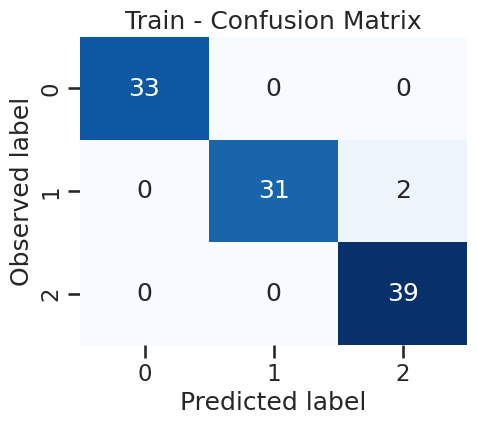

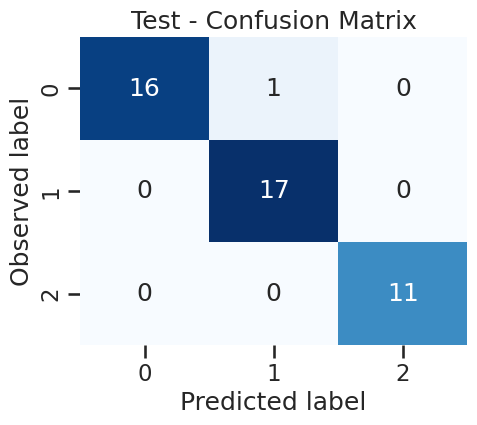

In [10]:
plot_confusion_matrix(y_data, pred_y, title='Train - Confusion Matrix')
plot_confusion_matrix(y_test, pred_y_test, title='Test - Confusion Matrix')

In [11]:
# Print the train/test accuracy
trainacc = np.array([mcmc.accuracy(pred_y[_,:], y_data) for _ in np.arange(pred_y.shape[0])])
testacc = np.array([mcmc.accuracy(pred_y_test[_,:], y_test) for _ in np.arange(pred_y_test.shape[0])])

print('Train accuracy: {:.3f}% ({:.3f})'.format(trainacc.mean(), trainacc.std()))
print('Test accuracy: {:.3f}% ({:.3f})'.format(testacc.mean(), testacc.std()))

Train accuracy: 97.565% (0.519)
Test accuracy: 97.982% (0.925)


In [12]:
def plot_hist(results, param_name):
    posterior_mean = results[param_name].mean()
    print('{:.3f} mean value of posterior'.format(posterior_mean))
    histogram_trace(results[param_name].values)

# use ipywidgets to get a "gui" dropdown to view all the parameters
interact(
    plot_hist, 
    results=fixed(results), 
    param_name=widgets.Dropdown(
        options=results.columns,
        value='w0',
        description='Parameter:',
    )
)

interactive(children=(Dropdown(description='Parameter:', options=('w0', 'w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w…

<function __main__.plot_hist(results, param_name)>

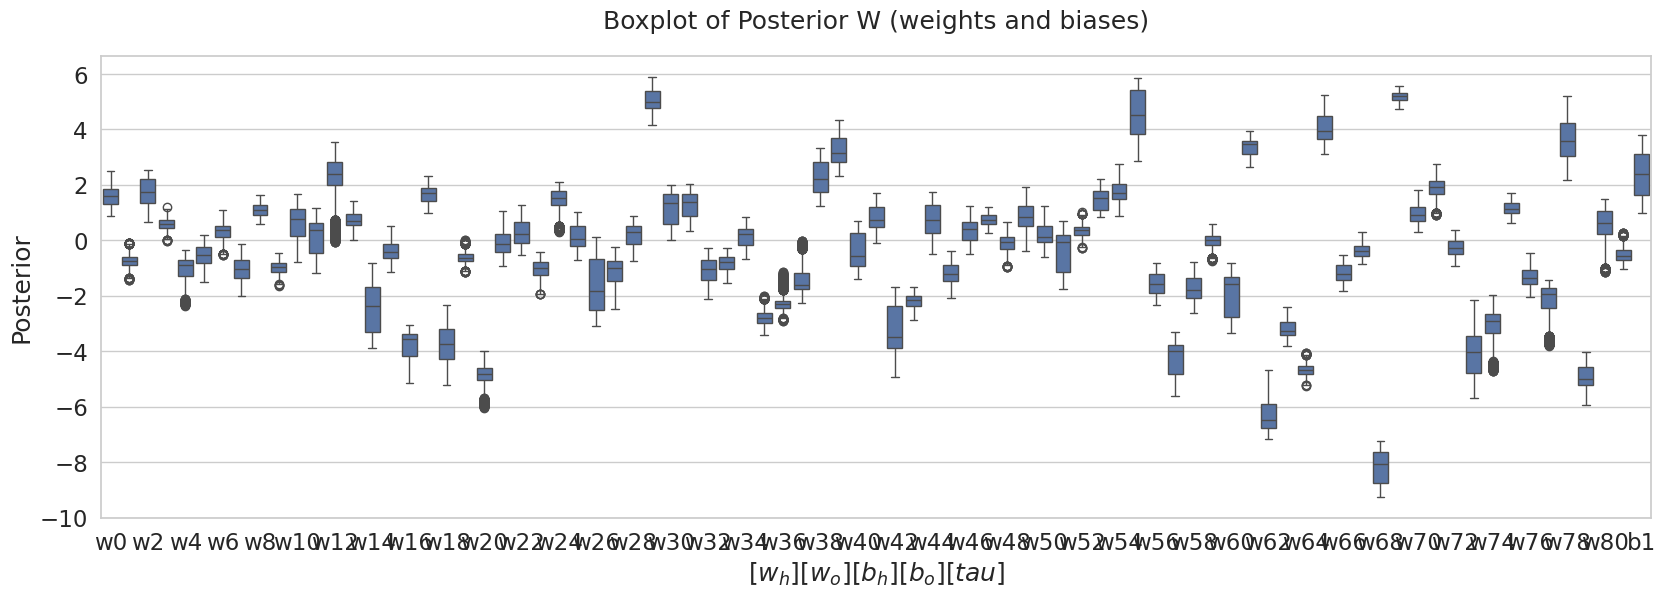

In [13]:
# Visualise all the network weights
boxplot_weights(results,width=20)